# 3本同じ方向に動いたら逆張り

In [395]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import datetime
from statistics import mean
from statistics import median
import calendar
import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb
import math

In [2]:
# OANDA API v20の口座IDとAPIトークン
accountID = "101-009-12609641-001"
access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"
# OANDAのデモ口座へのAPI接続
api = API(access_token=access_token, environment="practice")

## 関数定義

In [3]:
# APIから取得したレートをPandasのDataFrameへ
def to_dataframe(r):
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(float)
    return df

In [4]:
# 第何何曜日（第nX曜日）の日付を返す関数
def get_day_of_nth_dow(year, month, nth, dow):
    '''dow: Monday(0) - Sunday(6)'''
    if nth < 1 or dow < 0 or dow > 6:
        return None

    first_dow, n = calendar.monthrange(year, month)
    day = 7 * (nth - 1) + (dow - first_dow) % 7 + 1

    return day if day <= n else None

In [5]:
def get_data(count, gran, year, month, day, hour, minute, second):
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=hour, minute=minute, second=second).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from,
#         'dailyAlignment': 0
    }
    r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
    api.request(r)
    df = to_dataframe(r)
    return df

In [159]:
def get_data_super(start, end, gran):
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12789646-001"
    access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")
    # xxxx-xx-xx～xxxx-xx-xx の期間のデータを取得してデータフレームを返す
    s_year, s_month, s_day, s_hour, s_minute, s_second = map(int, start.split('-'))
    e_year, e_month, e_day, e_hour, e_minute, e_second = map(int, end.split('-'))
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    from_ = datetime.datetime(year=s_year, month=s_month, day=s_day,
                              hour=s_hour, minute=s_minute, second=s_second).strftime(fmt)
    to_ = datetime.datetime(year=e_year, month=e_month, day=e_day,
                            hour=e_hour, minute=e_minute, second=e_second).strftime(fmt)
    to_dt = '{}-{}-{} {}:{}:{}'.format(e_year, e_month, e_day, e_hour, e_minute, e_second)
    to_unix = datetime.datetime.strptime(to_dt, '%Y-%m-%d %H:%M:%S').timestamp()
    df = pd.DataFrame()
    # 5000個制限に引っかからなければこっちの処理
    try:
        params = {
            "granularity": gran,
            'from': from_,
            'to': to_
        }
        r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
        api.request(r)
        df = to_dataframe(r)
    # 引っかかればこっちの処理
    except:
        i = True
        while i:
            df_tmp = get_data(count=5000, gran=gran, year=s_year, month=s_month, day=s_day,
                             hour=s_hour, minute=s_minute, second=s_second)
            # ケツが同じなら止める (最新迄用)
            if df.tail(1).reset_index(drop=True).equals(df_tmp.tail(1).reset_index(drop=True)):
                i = False
            else:
                df = pd.concat([df, df_tmp[:-1]], ignore_index=True)
                index = df_tmp.tail(1).index[0]
                s_year = df_tmp.iat[index, 0].year
                s_month = df_tmp.iat[index, 0].month
                s_day = df_tmp.iat[index, 0].day
                s_hour = df_tmp.iat[index, 0].hour
                s_minute = df_tmp.iat[index, 0].minute
                s_second = df_tmp.iat[index, 0].second
                # 5000個ずつ取得してエンドの unix 超えたら止める
                if to_unix < df.iat[df.tail(1).index[0], 0].timestamp():
                    # はみ出した分をここで切り落とす
                    for i in range(len(df.index) - 5000, len(df.index)):
                        if to_unix <= df.iat[i, 0].timestamp():
                            df = df[:i]
                            break
                    i = False
    return df

In [336]:
def get_evaluation(pos_df):
    # 勝率
    win_c = pos_df[pos_df['pips'] >=0].shape[0]
    P = win_c / len(pos_df.index)
    print('勝率: {:.2f}%'.format(P*100))
    # ペイオフレシオ
    win_p = mean(pos_df[pos_df['pips'] >=0]['pips'])
    los_p = mean(pos_df[pos_df['pips'] < 0]['pips']) * (-1)
    R = win_p / los_p
    print('ペイオフレシオ: {:.4f}'.format(R))
    # プロフィットファクター
    pf = pos_df[pos_df['profit']>0]['profit'].sum() / pos_df[pos_df['profit']<=0]['profit'].sum() * (-1)
    print('プロフィットファクター: {:.4f}'.format(pf))
    # 期待値
    win_pro = mean(pos_df[pos_df['pips'] >=0]['profit'])
    los_pro = mean(pos_df[pos_df['pips'] < 0]['profit']) * (-1)
    E = P * win_pro - pos_df[pos_df['pips'] < 0].shape[0] / len(pos_df.index) * los_pro
    print('期待値: {:.3f}円'.format(E))
    dd = pos_df.sort_values(by='pips', ascending=True).head(1)['pips'].values[0]
    print('最大ドローダウン: {:.1f}pips'.format(dd))
    # ケリー基準
    kly = ((R + 1) * P - 1) / R
    print('ケリー基準: {:.2f}%'.format(kly*100))

In [237]:
# バックテスト
def back_test(df, m, seed_money, start='', end='', gran='M5'):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    tmp_i = 0
    assets = seed_money
    lot = 10
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    pos_df = pd.DataFrame(columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])

    # 実行
    for i in range(3, len(df.index) - (1+m)):
        entry_rate = df.iat[i, 2] # 始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値
        # up or down (Open - Close)
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud1 > 0 and ud2 > 0 and ud3 > 0:
            if pos == 'None':
                pips = (exit_rate - entry_rate - fee) * 100
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'long', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                pos = 'entry_long'
                tmp_i = i
        # 下降トレンドと判断しショート
        if ud1 < 0 and ud2 < 0 and ud3 < 0:
            if pos == 'None':
                pips = (entry_rate - exit_rate - fee) * 100
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'short', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                pos = 'entry_short'
                tmp_i = i
        
    print('pos count: {:>5}, profit: {:>6.3f}'.format(pos_df.shape[0], pos_df['profit'].sum()))
    return pos_df, df

In [241]:
# バックテスト簡易版
def back_test_easy(df, m, start='', end='', gran='M5'):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    profit_list = []
    pos_count = 0
    tmp_i = 0
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    # 実行
    for i in range(3, len(df.index) - (1+m)):
        entry_rate = df.iat[i, 2] # 始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値(exit)
        # up or down (Open - Close)
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud1 > 0 and ud2 > 0 and ud3 > 0:
            if pos == 'None':
                profit = exit_rate - entry_rate - fee
                profit_list.append(profit)
                pos = 'entry_long'
                pos_count+=1
                tmp_i = i
        # 下降トレンドと判断しショート
        if ud1 < 0 and ud2 < 0 and ud3 < 0:
            if pos == 'None':
                profit = entry_rate - exit_rate - fee
                profit_list.append(profit)
                pos = 'entry_short'
                pos_count+=1
                tmp_i = i
        
    print('pos count: {:>5}, profit: {:>6.3f}'.format(pos_count, sum(profit_list)))

## 検証

In [162]:
df = get_data_super('2010-01-01-00-00-00', '2019-01-01-00-00-00', 'M5')

In [242]:
for i in range(1, 50):
    print('m: {}, '.format(i), end='')
    back_test_easy(df, m=i)

m: 1, pos count: 136298, profit: -17.005
m: 2, pos count: 94357, profit: -9.219
m: 3, pos count: 83038, profit: -9.652
m: 4, pos count: 73894, profit: -13.953
m: 5, pos count: 66617, profit: -4.572
m: 6, pos count: 60665, profit: -7.320
m: 7, pos count: 55631, profit: -2.705
m: 8, pos count: 51385, profit: 28.073
m: 9, pos count: 47781, profit: 44.976
m: 10, pos count: 44602, profit: 41.435
m: 11, pos count: 41781, profit: 41.701
m: 12, pos count: 39296, profit:  8.767
m: 13, pos count: 37108, profit: 12.560
m: 14, pos count: 35207, profit: 29.234
m: 15, pos count: 33400, profit: 32.883
m: 16, pos count: 31801, profit: 11.796
m: 17, pos count: 30400, profit: 17.051
m: 18, pos count: 29111, profit: 13.339
m: 19, pos count: 27929, profit: 29.878
m: 20, pos count: 26785, profit: 34.135
m: 21, pos count: 25788, profit: 48.174
m: 22, pos count: 24846, profit: 22.548
m: 23, pos count: 23991, profit: 25.485
m: 24, pos count: 23114, profit:  6.920
m: 25, pos count: 22348, profit: -1.851
m: 26,

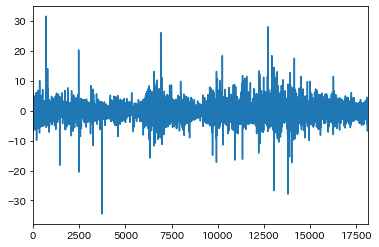

In [246]:
pos_df['profit'].plot()

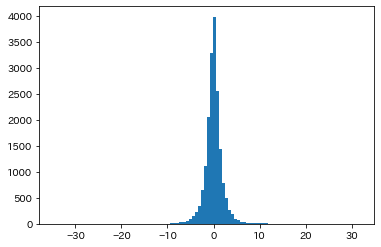

In [245]:
plt.hist(pos_df['profit'], bins=100)
plt.show()

In [331]:
pos_df, df = back_test(df, m=34, seed_money=1000000)

pos count: 17228, profit: 696.790


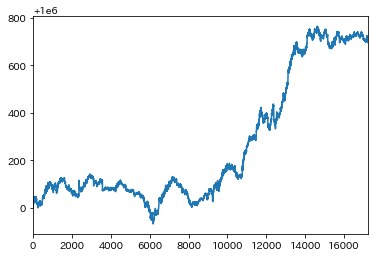

In [332]:
pos_df['assets'].plot()

In [337]:
get_evaluation(pos_df)

勝率: 50.85%
ペイオフレシオ: 1.0257
プロフィットファクター: 1.0614
期待値: 0.040円
最大ドローダウン: -345.2pips
ケリー基準: 2.94%


In [375]:
pos_df.sort_values(by='pips', ascending=True).head()

,lot,l_or_s,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
3567,10,short,2011-10-31 00:55:00+00:00,75.748,2011-10-31 03:45:00+00:00,79.198,-345.2,-34.52,1000081.73
12384,10,long,2016-06-24 00:35:00+00:00,104.812,2016-06-24 03:25:00+00:00,101.490,-332.4,-33.24,1000397.81
12078,10,long,2016-04-28 02:55:00+00:00,111.682,2016-04-28 05:45:00+00:00,109.010,-267.4,-26.74,1000352.16
2367,10,short,2011-03-17 23:55:00+00:00,79.419,2011-03-18 02:45:00+00:00,81.570,-215.3,-21.53,1000094.73
9235,10,short,2014-10-31 04:35:00+00:00,109.374,2014-10-31 07:25:00+00:00,111.404,-203.2,-20.32,1000031.90


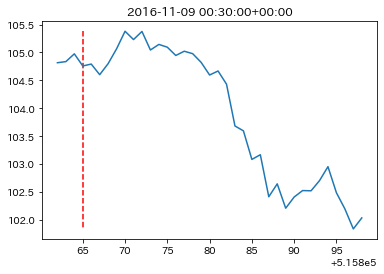

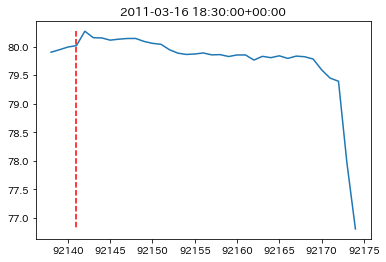

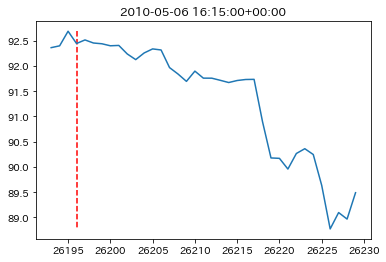

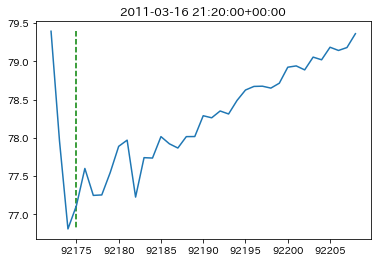

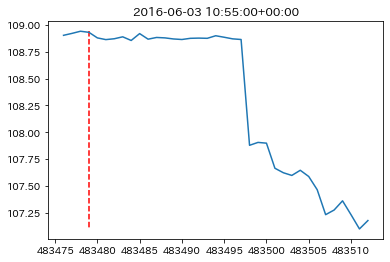

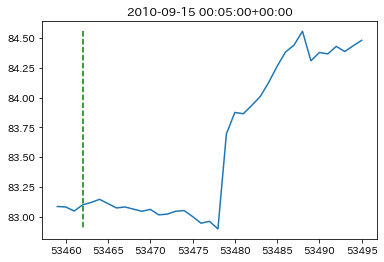

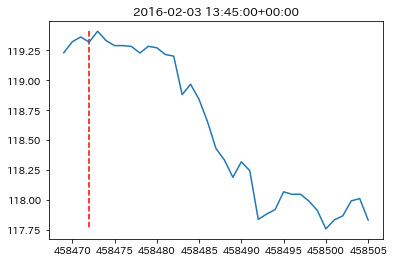

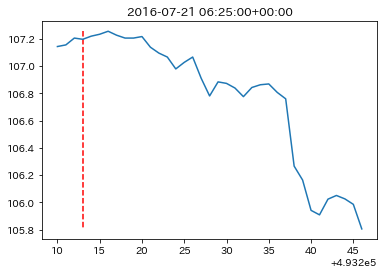

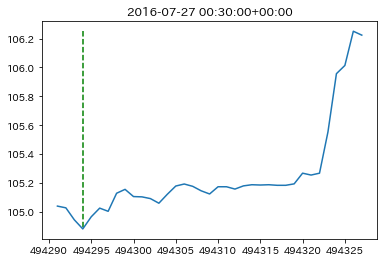

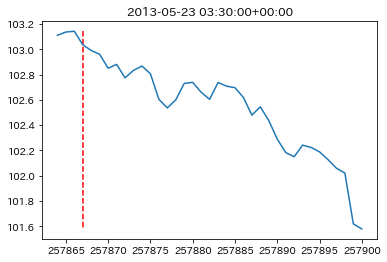

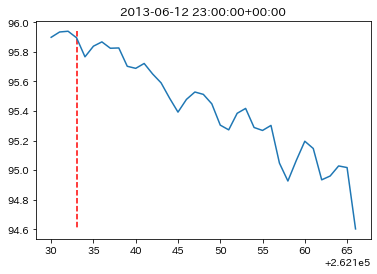

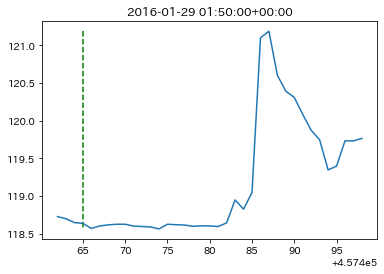

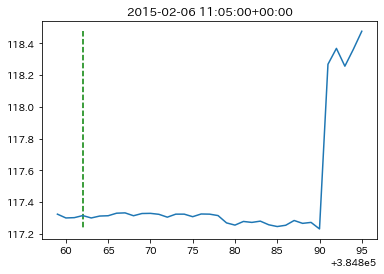

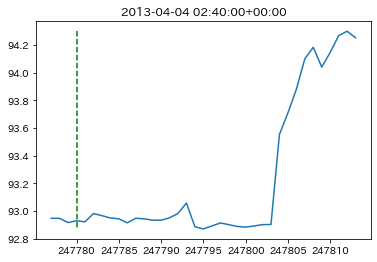

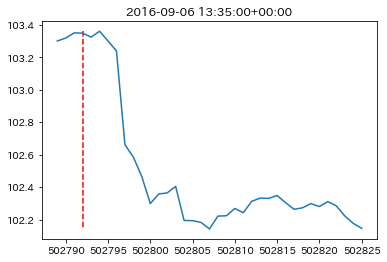

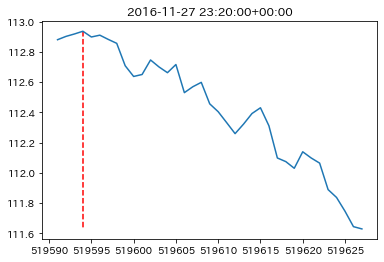

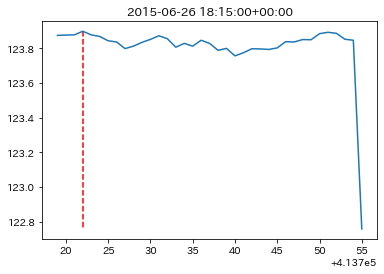

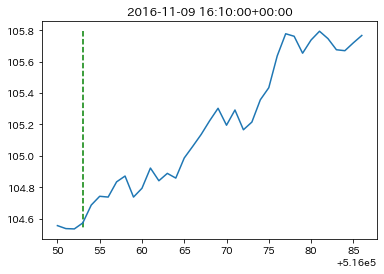

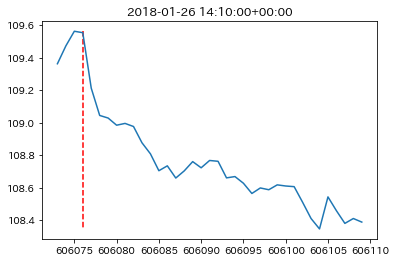

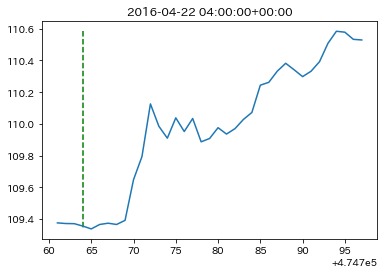

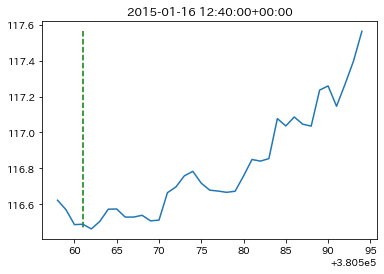

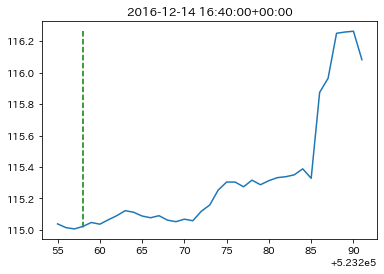

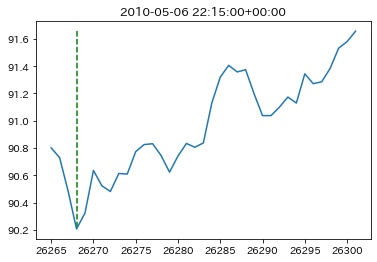

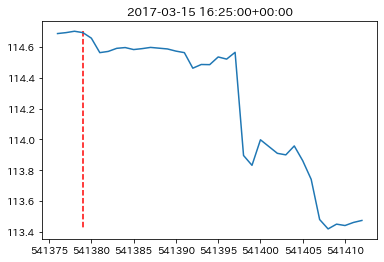

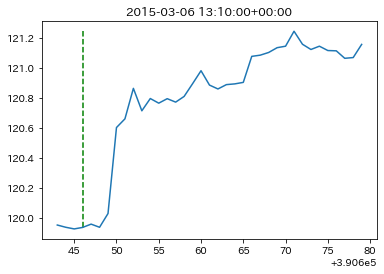

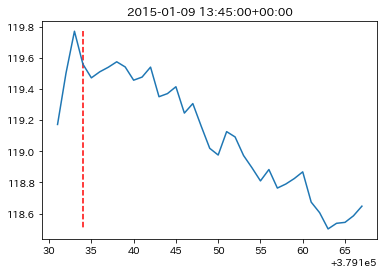

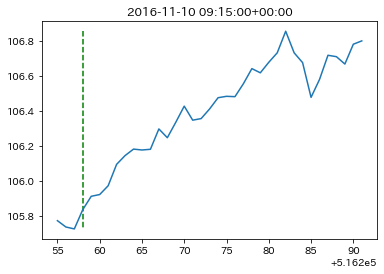

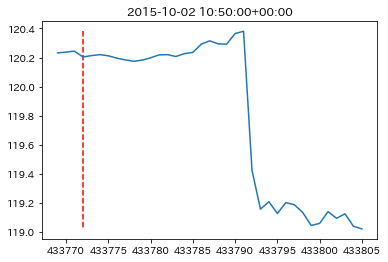

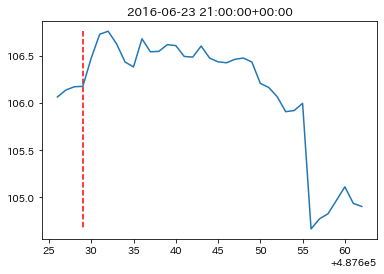

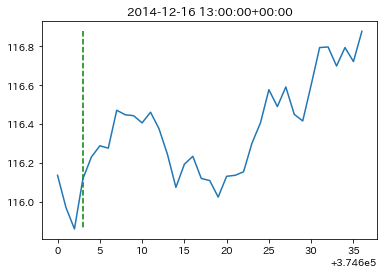

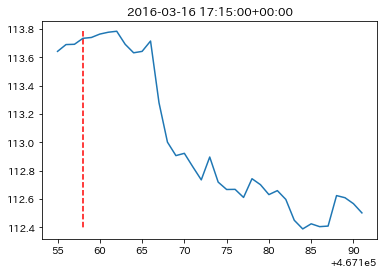

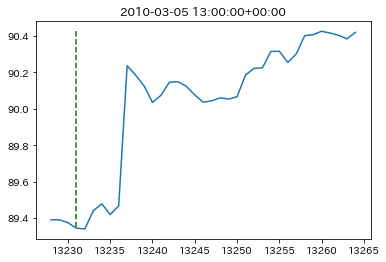

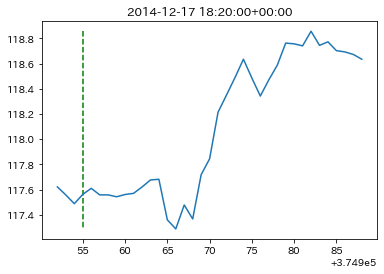

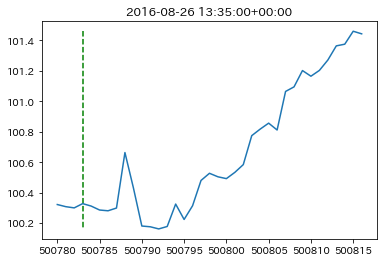

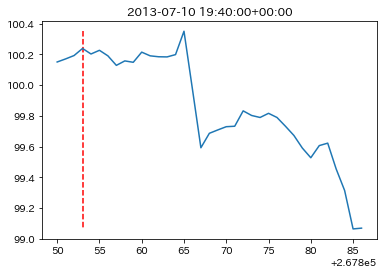

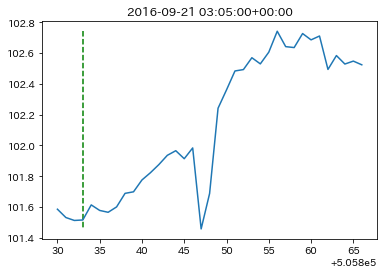

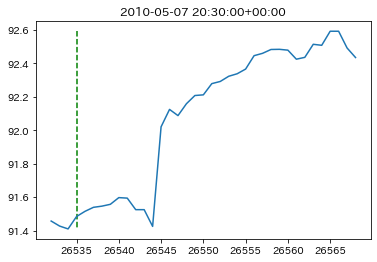

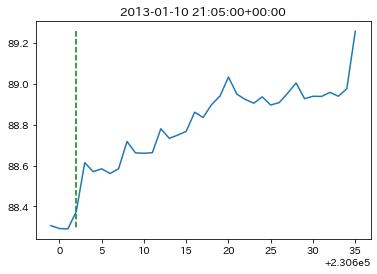

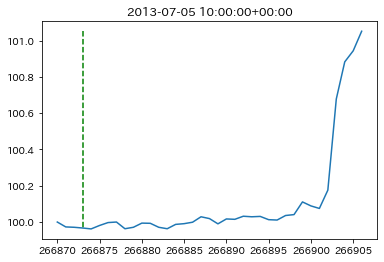

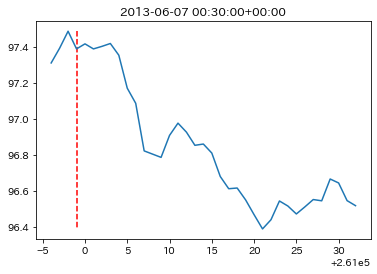

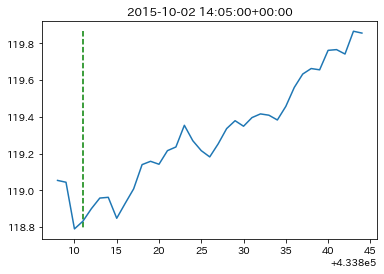

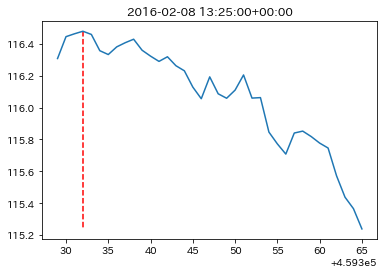

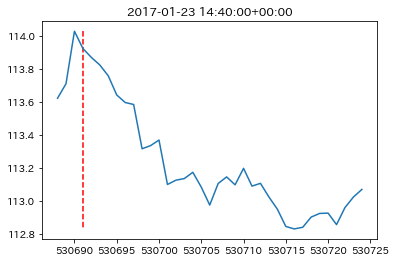

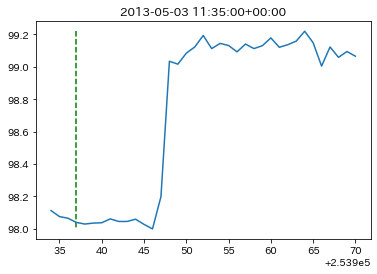

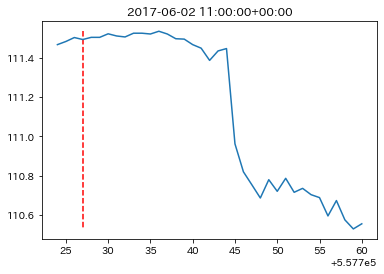

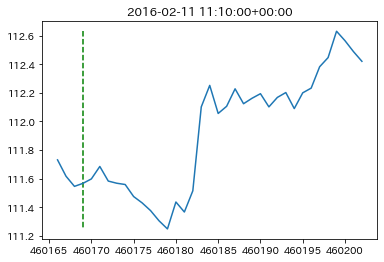

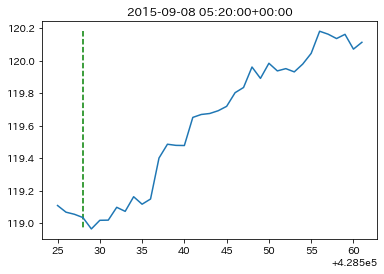

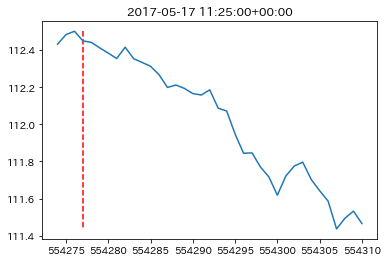

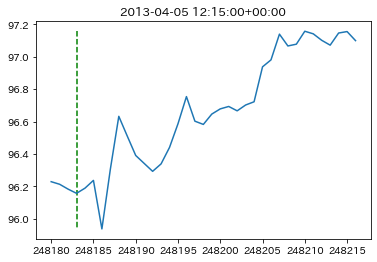

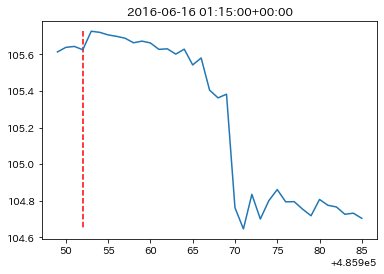

In [378]:
for idx in pos_df.sort_values(by='pips', ascending=False).head(50).index:
    entry_date = pos_df[idx:idx+1]['entry_date'].values[0]
    i = df[df['Time']==entry_date].index[0]
    m = 34
    plt.title(entry_date)
    plt.plot(df[i-3:i+m]['Close'])
    plt.vlines(i, df[i-3:i+m]['Close'].max(), df[i-3:i+m]['Close'].min(),
              "green" if pos_df[idx:idx+1]['l_or_s'].values[0]=='long' else 'red', linestyles='dashed')
    plt.show()

### 年別プロット

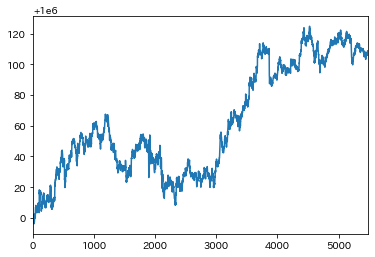

In [339]:
pos_dff[pos_dff['entry_date'].dt.year==2010]['assets'].plot()

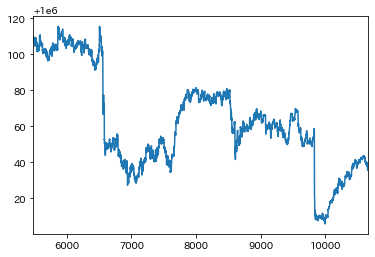

In [340]:
pos_dff[pos_dff['entry_date'].dt.year==2011]['assets'].plot()

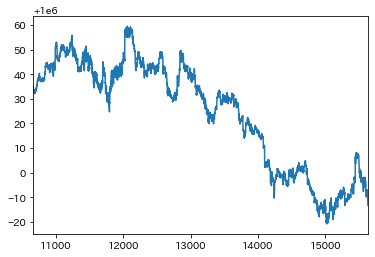

In [341]:
pos_dff[pos_dff['entry_date'].dt.year==2012]['assets'].plot()

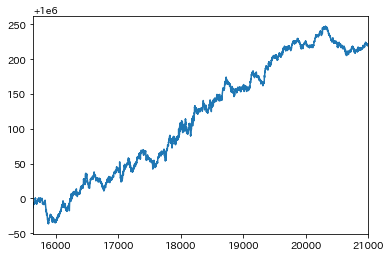

In [342]:
pos_dff[pos_dff['entry_date'].dt.year==2013]['assets'].plot()

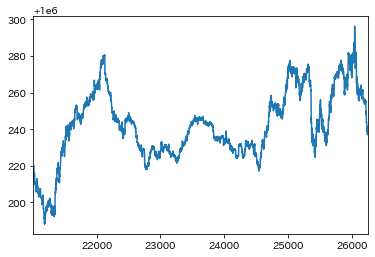

In [343]:
pos_dff[pos_dff['entry_date'].dt.year==2014]['assets'].plot()

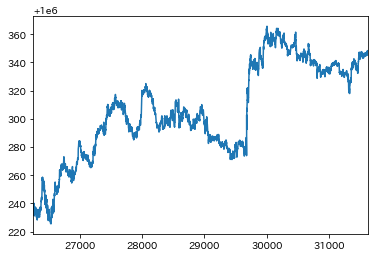

In [344]:
pos_dff[pos_dff['entry_date'].dt.year==2015]['assets'].plot()

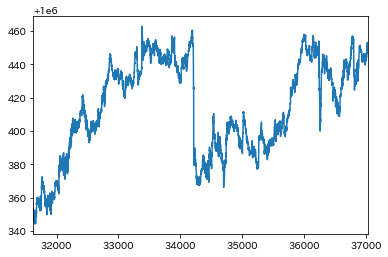

In [345]:
pos_dff[pos_dff['entry_date'].dt.year==2016]['assets'].plot()

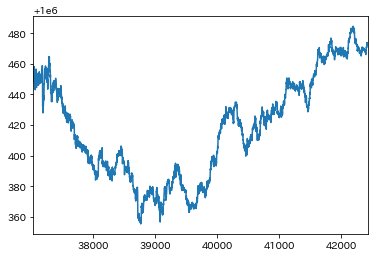

In [346]:
pos_dff[pos_dff['entry_date'].dt.year==2017]['assets'].plot()

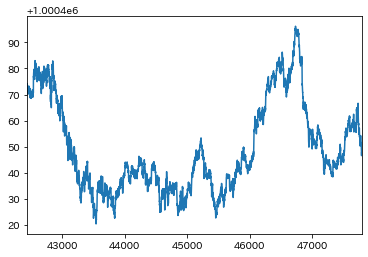

In [347]:
pos_dff[pos_dff['entry_date'].dt.year==2018]['assets'].plot()

### 改良

In [428]:
# バックテスト2
def back_test2(df, m, seed_money, start='', end='', gran='M5', lot=10, kly_rate='None'):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    tmp_i = 0
    assets = seed_money
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    pos_df = pd.DataFrame(columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])

    # 実行
    for i in range(3, len(df.index) - (1+m)):
        entry_rate = df.iat[i, 2] # 始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値
        # up or down (Open - Close)
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud1 > ud2 > ud3 > 0:
            if pos == 'None':
                pips = (exit_rate - entry_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'long', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                if pos_df.tail(1)['assets'].values[0] < 0:
                    break
                pos = 'entry_long'
                tmp_i = i
        # 下降トレンドと判断しショート
        if 0 > ud3 > ud2 > ud1:
            if pos == 'None':
                pips = (entry_rate - exit_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'short', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                if pos_df.tail(1)['assets'].values[0] < 0:
                    break
                pos = 'entry_short'
                tmp_i = i
        
    print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df, df

In [379]:
# バックテスト簡易版2
def back_test_easy2(df, m, start='', end='', gran='M5'):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    profit_list = []
    pos_count = 0
    tmp_i = 0
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    # 実行
    for i in range(3, len(df.index) - (1+m)):
        entry_rate = df.iat[i, 2] # 始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値(exit)
        # up or down (Open - Close) + なら赤 - なら緑
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud1 > ud2 > ud3 > 0:
            if pos == 'None':
                profit = exit_rate - entry_rate - fee
                profit_list.append(profit)
                pos = 'entry_long'
                pos_count+=1
                tmp_i = i
        # 下降トレンドと判断しショート
        if 0 > ud3 > ud2 > ud1:
            if pos == 'None':
                profit = entry_rate - exit_rate - fee
                profit_list.append(profit)
                pos = 'entry_short'
                pos_count+=1
                tmp_i = i
        
    print('pos count: {:>5}, profit: {:>6.3f}'.format(pos_count, sum(profit_list)))

In [382]:
for i in range(1, 50):
    print('m: {}, '.format(i), end='')
    back_test_easy2(df, m=i)

m: 1, pos count: 22805, profit: 10.478
m: 2, pos count: 20484, profit:  4.572
m: 3, pos count: 20284, profit: -4.849
m: 4, pos count: 19669, profit: 16.083
m: 5, pos count: 19116, profit: 16.840
m: 6, pos count: 18643, profit:  7.804
m: 7, pos count: 18168, profit: 19.359
m: 8, pos count: 17674, profit: 23.798
m: 9, pos count: 17242, profit: 24.977
m: 10, pos count: 16787, profit: 16.236
m: 11, pos count: 16378, profit:  5.546
m: 12, pos count: 16001, profit: 13.026
m: 13, pos count: 15609, profit: 13.119
m: 14, pos count: 15274, profit:  9.891
m: 15, pos count: 14930, profit: 13.830
m: 16, pos count: 14626, profit: 21.130
m: 17, pos count: 14284, profit: 19.795
m: 18, pos count: 13994, profit: 23.456
m: 19, pos count: 13683, profit: 22.807
m: 20, pos count: 13404, profit: 17.479
m: 21, pos count: 13134, profit: 12.413
m: 22, pos count: 12871, profit: 11.881
m: 23, pos count: 12626, profit: 11.086
m: 24, pos count: 12370, profit: 31.188
m: 25, pos count: 12151, profit: 25.475
m: 26, po

In [384]:
pos_df, df = back_test2(df, m=24, seed_money=1000000)

pos count: 12370, profit: 311.880


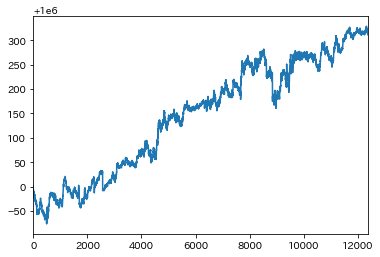

In [385]:
pos_df['assets'].plot()

In [388]:
pos_df2, df = back_test2(df, m=26, seed_money=1000000)

pos count: 11939, profit: 346.160


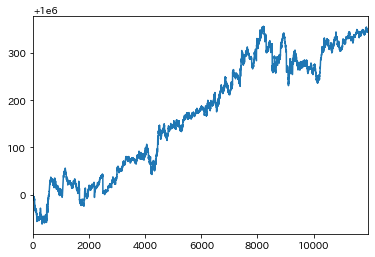

In [389]:
pos_df2['assets'].plot()

In [390]:
get_evaluation(pos_df)

勝率: 52.17%
ペイオフレシオ: 0.9570
プロフィットファクター: 1.0440
期待値: 0.025円
最大ドローダウン: -345.2pips
ケリー基準: 2.20%


In [391]:
get_evaluation(pos_df2)

勝率: 52.56%
ペイオフレシオ: 0.9468
プロフィットファクター: 1.0490
期待値: 0.029円
最大ドローダウン: -345.2pips
ケリー基準: 2.45%


In [436]:
pos_df3, df = back_test2(df, m=26, seed_money=1000000, kly_rate=1)

pos count: 11939, assets: 1369834円


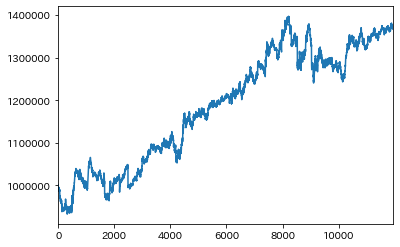

In [437]:
pos_df3['assets'].plot()

In [438]:
pos_df3.sort_values(by='assets')

,lot,l_or_s,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
319,10110,long,2010-03-26 13:25:00+00:00,92.784,2010-03-26 15:35:00+00:00,92.538,-24.8,-2507.280,933132.370
323,10098,short,2010-03-28 23:00:00+00:00,92.448,2010-03-29 01:10:00+00:00,92.566,-12.0,-1211.760,933586.687
324,10079,short,2010-03-29 04:00:00+00:00,92.686,2010-03-29 06:10:00+00:00,92.624,6.0,604.740,934191.427
334,10033,short,2010-03-31 01:00:00+00:00,93.128,2010-03-31 03:10:00+00:00,93.224,-9.8,-983.234,934368.001
321,10114,long,2010-03-28 18:20:00+00:00,92.430,2010-03-28 20:30:00+00:00,92.411,-2.1,-212.394,934464.817
320,10097,short,2010-03-26 19:15:00+00:00,92.568,2010-03-28 18:20:00+00:00,92.413,15.3,1544.841,934677.211
322,10110,short,2010-03-28 20:30:00+00:00,92.463,2010-03-28 22:40:00+00:00,92.428,3.3,333.630,934798.447
317,10105,short,2010-03-26 03:55:00+00:00,92.516,2010-03-26 06:05:00+00:00,92.550,-3.6,-363.780,934913.026
407,10175,short,2010-04-18 21:30:00+00:00,91.883,2010-04-18 23:40:00+00:00,91.986,-10.5,-1068.375,934958.858
325,10092,short,2010-03-29 07:00:00+00:00,92.656,2010-03-29 09:10:00+00:00,92.560,9.4,948.648,935140.075


In [439]:
pos_df3.sort_values(by='profit')

,lot,l_or_s,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
2488,13209,short,2011-10-31 00:55:00+00:00,75.748,2011-10-31 03:05:00+00:00,79.198,-345.2,-45597.468,1000596.877
9031,13048,long,2016-11-09 01:50:00+00:00,104.596,2016-11-09 04:00:00+00:00,101.935,-266.3,-34746.824,1295347.177
8311,12469,long,2016-04-28 02:10:00+00:00,111.678,2016-04-28 04:20:00+00:00,109.341,-233.9,-29164.991,1334276.769
8529,12894,long,2016-06-24 02:25:00+00:00,103.666,2016-06-24 04:35:00+00:00,101.482,-218.6,-28186.284,1280406.982
1654,12373,short,2011-03-17 23:55:00+00:00,79.419,2011-03-18 02:05:00+00:00,81.448,-203.1,-25129.563,982696.673
8528,12808,long,2016-06-23 23:05:00+00:00,105.918,2016-06-24 01:15:00+00:00,104.043,-187.7,-24040.616,1308593.266
2187,12901,short,2011-08-04 00:30:00+00:00,77.102,2011-08-04 02:40:00+00:00,78.780,-168.0,-21673.680,994744.670
4188,11560,short,2013-04-04 03:45:00+00:00,92.982,2013-04-04 05:55:00+00:00,94.620,-164.0,-18958.400,1074867.168
9179,11120,short,2016-12-14 18:55:00+00:00,115.391,2016-12-14 21:05:00+00:00,117.024,-163.5,-18181.200,1283174.596
8525,12741,short,2016-06-23 09:05:00+00:00,104.580,2016-06-23 11:15:00+00:00,105.734,-115.6,-14728.596,1332520.515


In [434]:
pos_df4, df = back_test2(df, m=26, seed_money=1000000, lot=100000)

pos count: 11939, assets: 4461600円


In [444]:
get_evaluation(pos_df4)

勝率: 52.56%
ペイオフレシオ: 0.9468
プロフィットファクター: 1.0490
期待値: 289.941円
最大ドローダウン: -345.2pips
ケリー基準: 2.45%


In [536]:
pos_df_m1, df = back_test2(dfm1[dfm1['Time'].dt.year==2013], m=24, seed_money=1000000)

pos count:  6651, assets: 1000044円


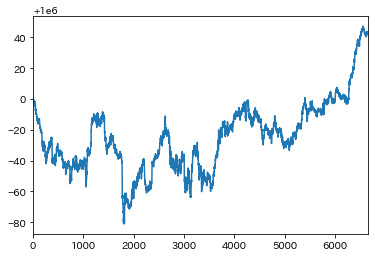

In [537]:
pos_df_m1['assets'].plot()

### M1 + 順張り

In [445]:
dfm1 = get_data_super('2010-01-01-00-00-00', '2019-01-01-00-00-00', 'M1')

In [512]:
# バックテスト簡易版3
def back_test_easy3(df, m, start='', end='', gran='M1'):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    profit_list = []
    pos_count = 0
    tmp_i = 0
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    # 実行
    for i in range(4, len(df.index) - (1+m)):
        entry_rate = df.iat[i, 2] # 始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値(exit)
        # up or down (Open - Close) + なら下げ - なら上げ
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        ud4 = df.iat[i-4, 2] - df.iat[i-4, 5]
        range_ = abs((ud1 + ud2 + ud3) / 3)
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud4 > 0 and ud1 < 0 and ud2 < 0 and ud3 < 0 and range_ < 0.005:
            if pos == 'None':
                profit = exit_rate - entry_rate - fee
                profit_list.append(profit)
                pos = 'entry_long'
                pos_count+=1
                tmp_i = i
        # 下降トレンドと判断しショート
        if ud4 < 0 and ud1 > 0 and ud2 > 0 and ud3 > 0 and range_ < 0.005:
            if pos == 'None':
                profit = entry_rate - exit_rate - fee
                profit_list.append(profit)
                pos = 'entry_short'
                pos_count+=1
                tmp_i = i
        
    print('pos count: {:>5}, profit: {:>6.3f}'.format(pos_count, sum(profit_list)))

In [514]:
# バックテスト3
def back_test3(df, m, seed_money, start='', end='', gran='M1', lot=10, kly_rate='None'):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    tmp_i = 0
    assets = seed_money
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    pos_df = pd.DataFrame(columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])

    # 実行
    for i in range(4, len(df.index) - (1+m)):
        entry_rate = df.iat[i, 2] # 始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値
        # up or down (Open - Close) + なら下げ - なら上げ
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        ud4 = df.iat[i-4, 2] - df.iat[i-4, 5]
        range_ = abs((ud1 + ud2 + ud3) / 3)
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud4 > 0 and ud3 < 0 and ud2 < 0 and ud1 < 0 and range_ < 0.008:
            if pos == 'None':
                pips = (exit_rate - entry_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'long', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                if pos_df.tail(1)['assets'].values[0] < 0:
                    break
                pos = 'entry_long'
                tmp_i = i
        # 下降トレンドと判断しショート
        if ud4 < 0 and ud3 > 0 and ud2 > 0 and ud1 > 0 and range_ < 0.008:
            if pos == 'None':
                pips = (entry_rate - exit_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'short', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                if pos_df.tail(1)['assets'].values[0] < 0:
                    break
                pos = 'entry_short'
                tmp_i = i
        
    print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df, df

In [502]:
for i in range(1, 50):
    print('m: {}, '.format(i), end='')
    back_test_easy3(dfm1[dfm1['Time'].dt.year==2018], m=i)

m: 1, pos count: 29892, profit: -70.861
m: 2, pos count: 29892, profit: -78.091
m: 3, pos count: 29892, profit: -78.045
m: 4, pos count: 27059, profit: -72.733
m: 5, pos count: 25088, profit: -71.414
m: 6, pos count: 23359, profit: -66.884
m: 7, pos count: 21869, profit: -61.132
m: 8, pos count: 20502, profit: -57.195
m: 9, pos count: 19375, profit: -55.961
m: 10, pos count: 18382, profit: -50.596
m: 11, pos count: 17443, profit: -51.937
m: 12, pos count: 16583, profit: -48.154
m: 13, pos count: 15805, profit: -47.163
m: 14, 

KeyboardInterrupt: 

In [520]:
for i in range(1, 50):
    print('m: {}, '.format(i), end='')
    back_test_easy3(dfm1[dfm1['Time'].dt.year==2018], m=i)

m: 1, pos count:  6600, profit: -12.767
m: 2, pos count:  6600, profit: -11.522
m: 3, pos count:  6600, profit: -12.325
m: 4, pos count:  6400, profit: -11.726
m: 5, pos count:  6246, profit: -12.000
m: 6, 

KeyboardInterrupt: 

In [515]:
pos_df_m1, df = back_test3(dfm1[dfm1['Time'].dt.year==2018], m=5, seed_money=1000000)

pos count: 13573, assets: 999705円


In [509]:
def entry_plot(pos_df, df, type_='head', n=50, m=20, b=3):
    if type_ == 'head':
        indexes = pos_df.head(n).index
    elif type_ == 'lose_head':
        indexes = pos_df[pos_df['pips']<0].head(n).index
    elif type_ == 'win_head':
        indexes = pos_df[pos_df['pips']>=0].head(n).index
    elif type_ == 'sort_t':
        indexes = pos_df.sort_values(by='pips', ascending=True).head(n).index
    elif type_ == 'sort_f':
        indexes = pos_df.sort_values(by='pips', ascending=False).head(n).index
    for idx in indexes:
        entry_date = pos_df[idx:idx+1]['entry_date'].values[0]
        l_or_s = pos_df[idx:idx+1]['l_or_s'].values[0]
        i = df[df['Time']==entry_date].index[0]
        plt.title(entry_date)
        plt.plot(df[i-b:i+m]['Open'], 'C1o', label="Open")
        plt.plot(df[i-b:i+m]['Close'], 'C0o', label="Close")
        plt.vlines(i, df[i-b:i+m]['Close'].max(), df[i-b:i+m]['Close'].min(),
                  "green" if l_or_s =='long' else 'red', linestyles='dashed', label=l_or_s)
        plt.legend()
        plt.show()

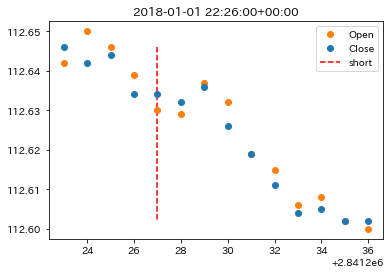

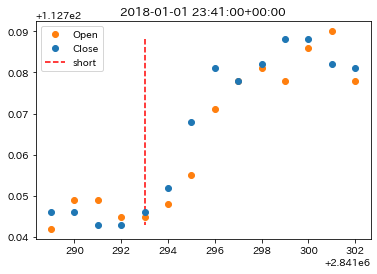

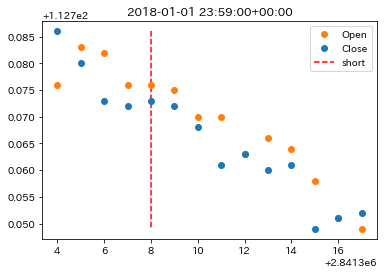

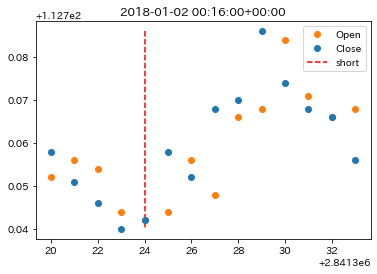

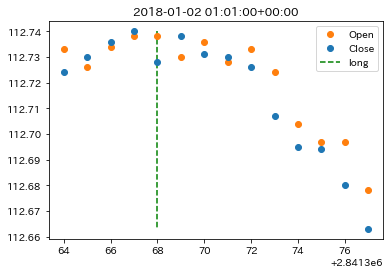

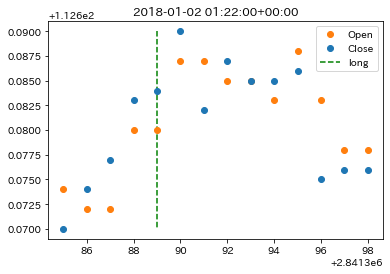

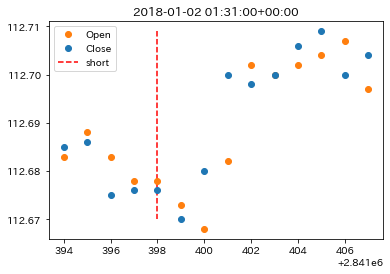

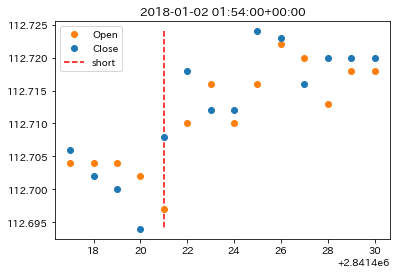

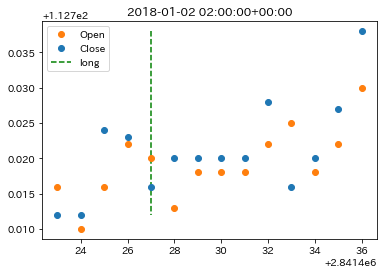

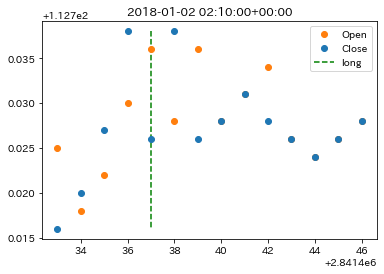

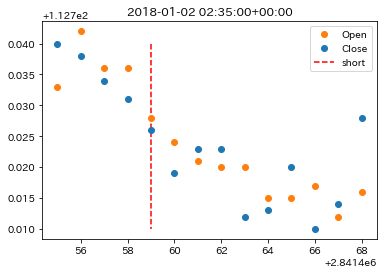

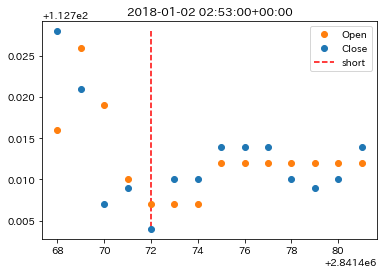

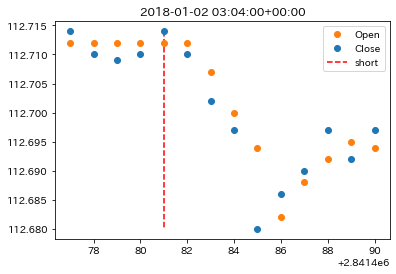

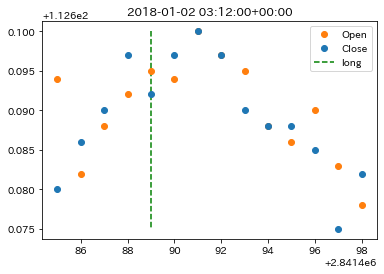

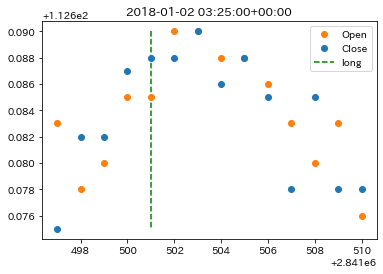

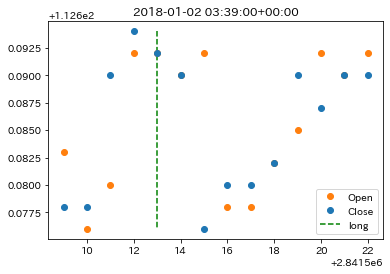

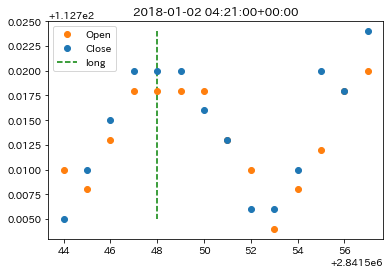

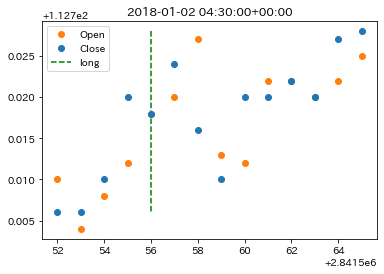

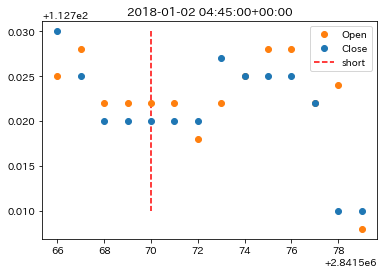

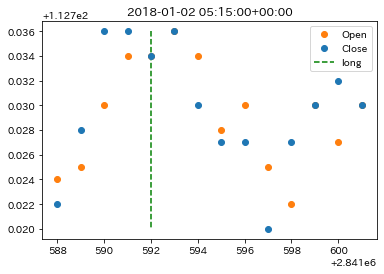

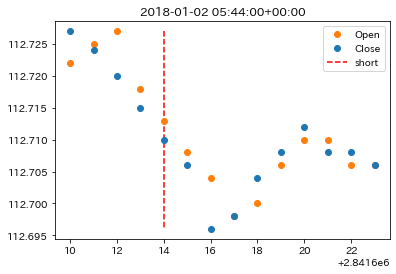

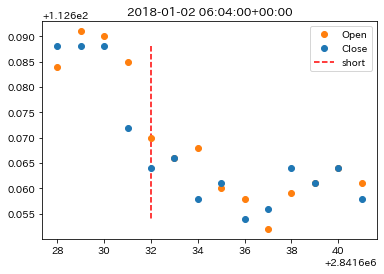

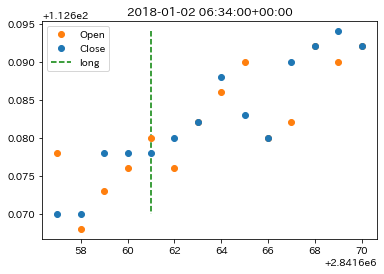

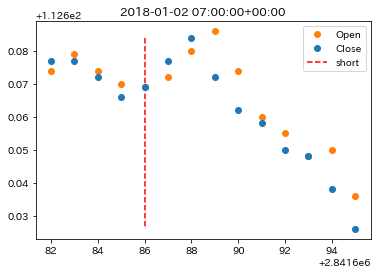

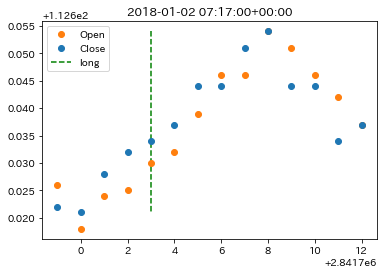

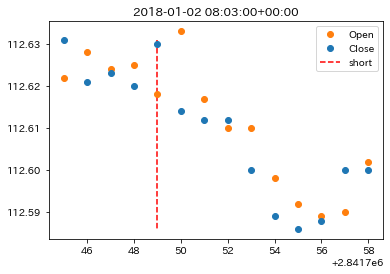

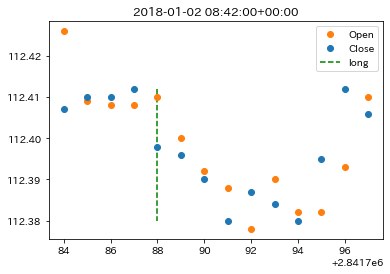

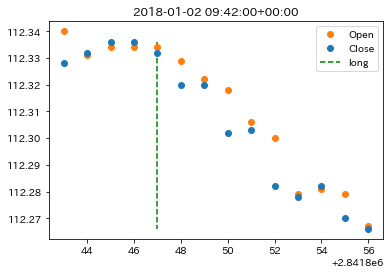

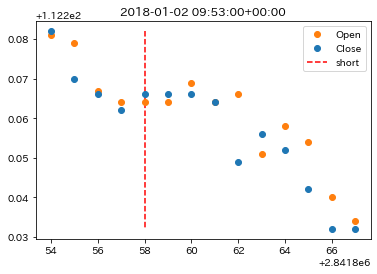

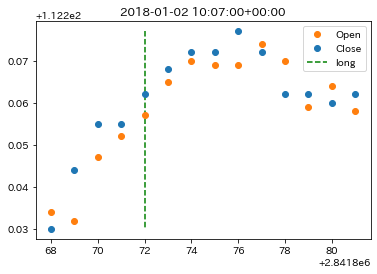

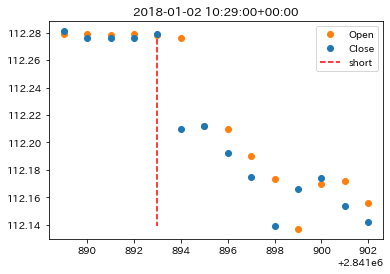

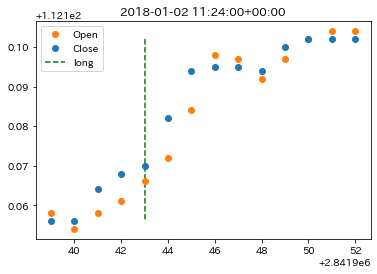

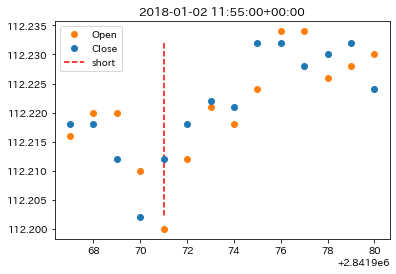

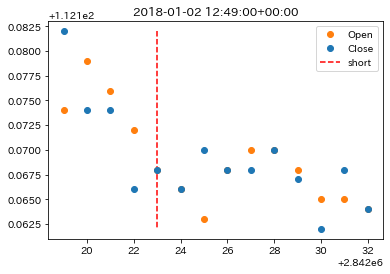

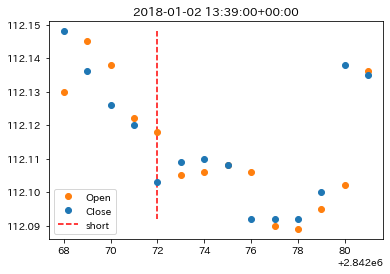

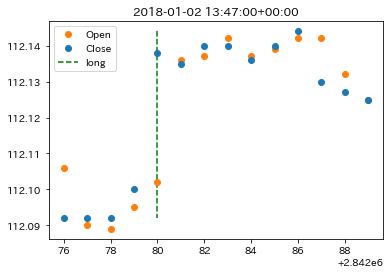

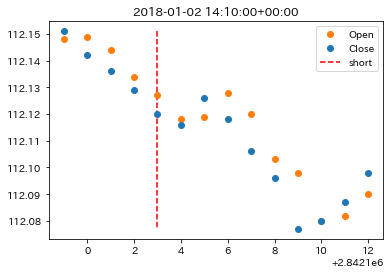

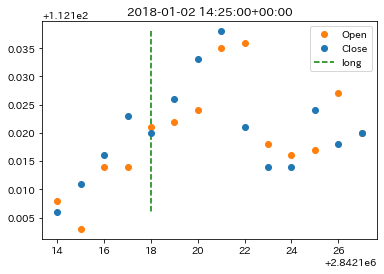

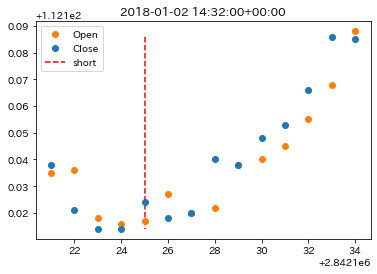

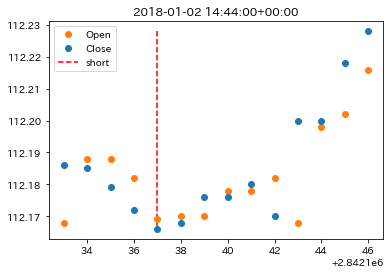

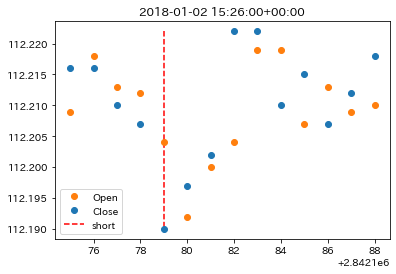

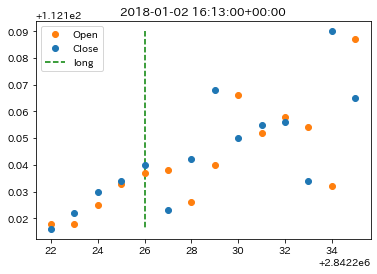

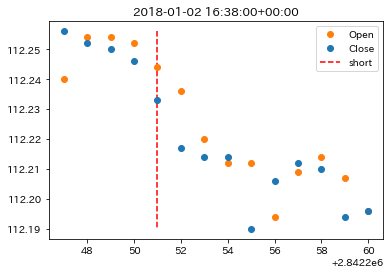

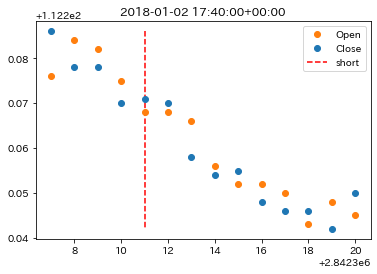

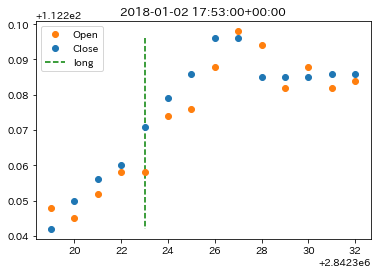

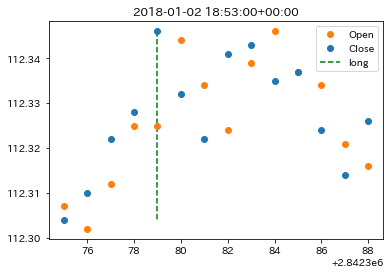

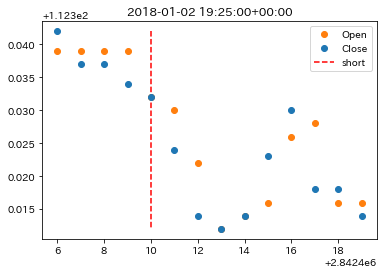

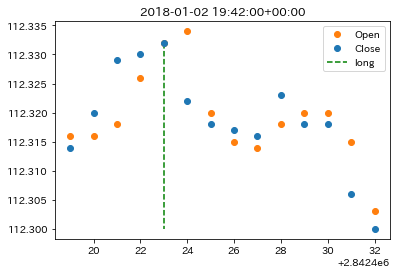

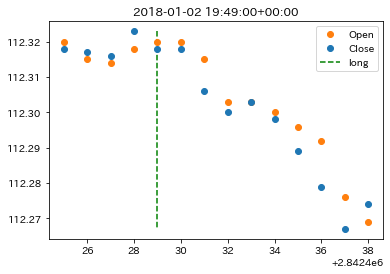

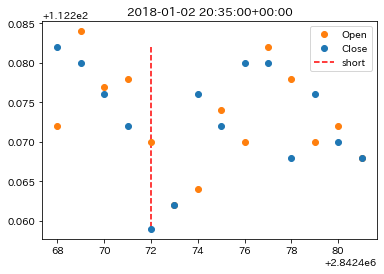

In [516]:
entry_plot(pos_df_m1, dfm1, m=10, b=4)

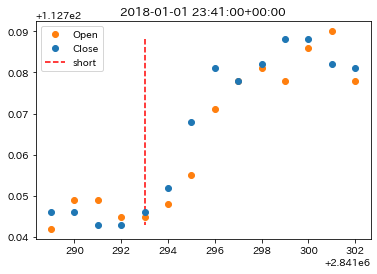

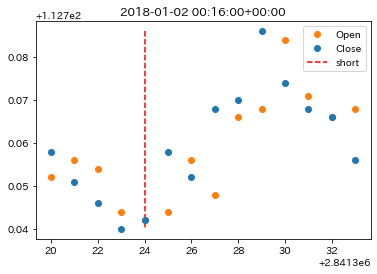

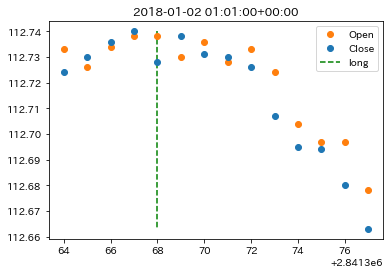

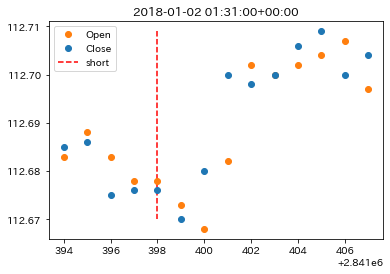

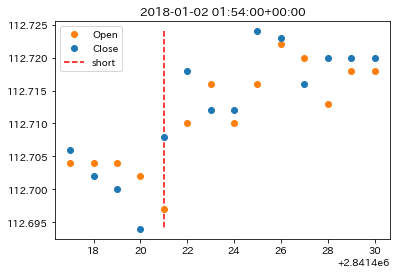

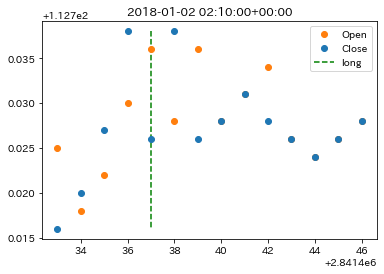

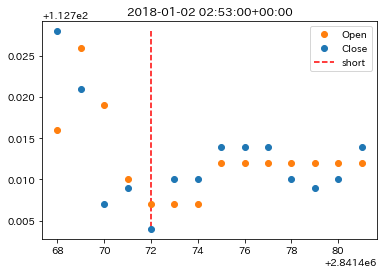

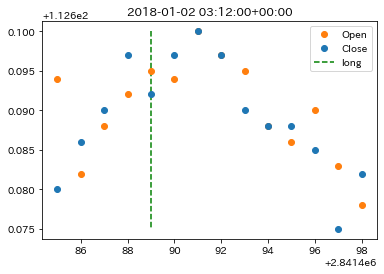

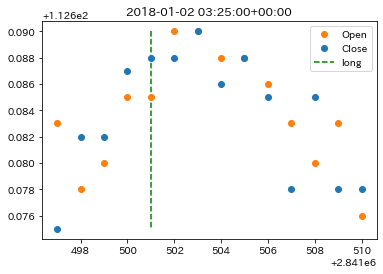

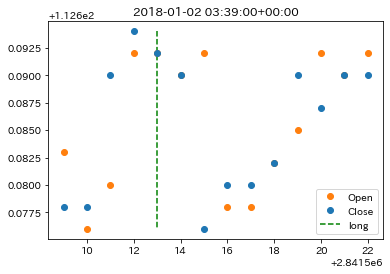

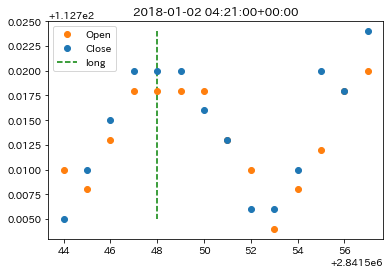

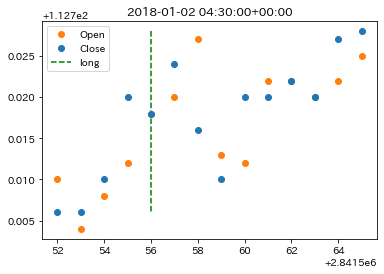

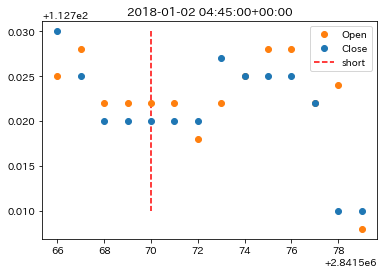

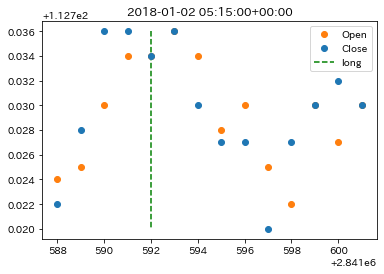

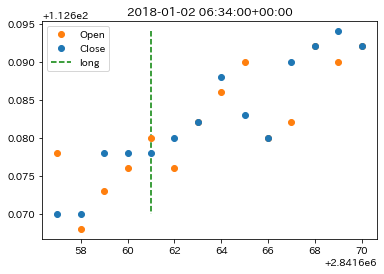

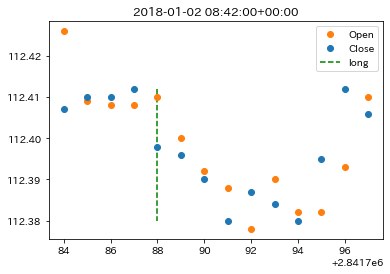

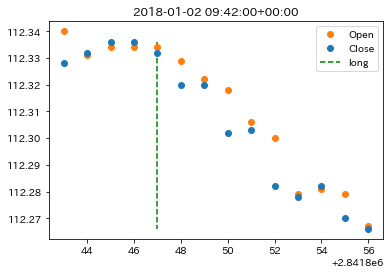

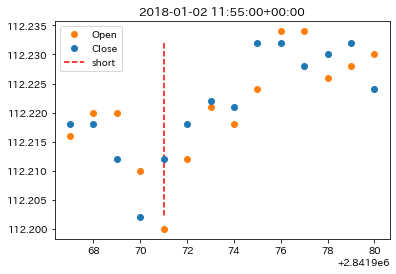

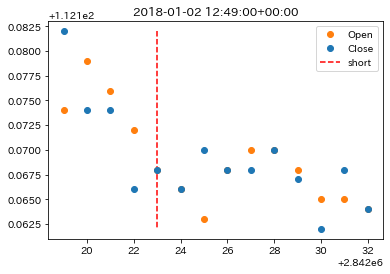

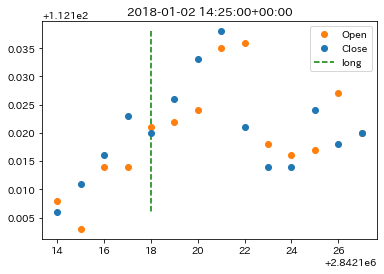

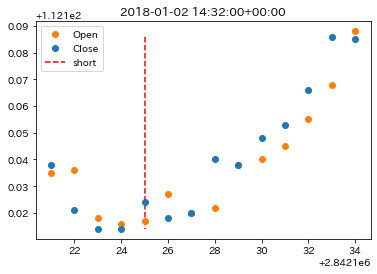

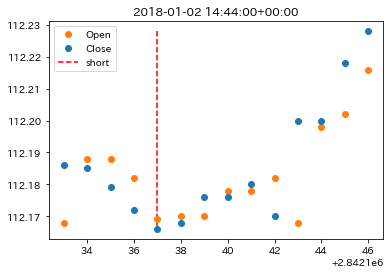

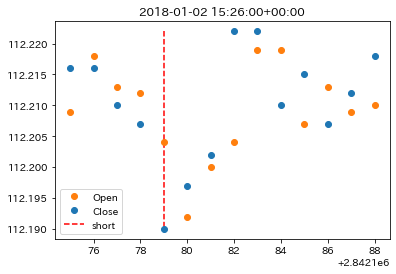

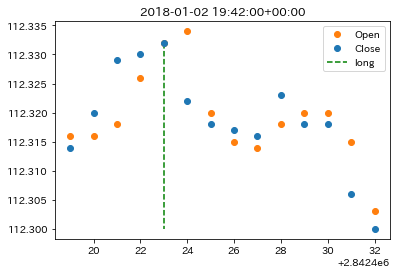

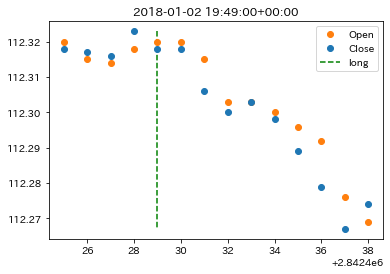

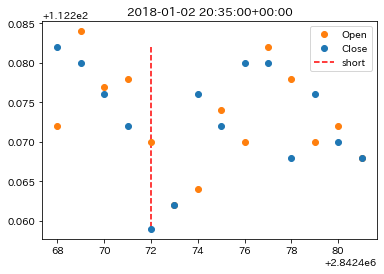

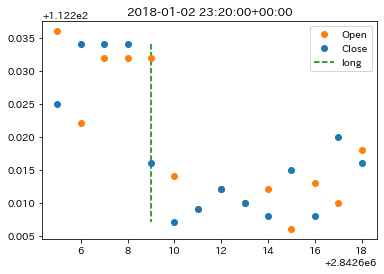

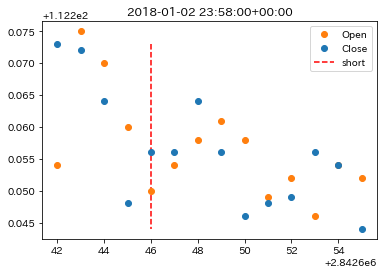

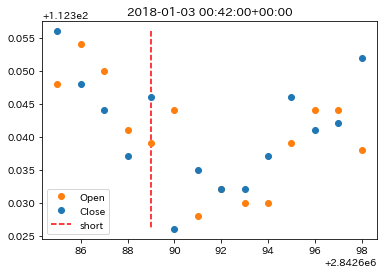

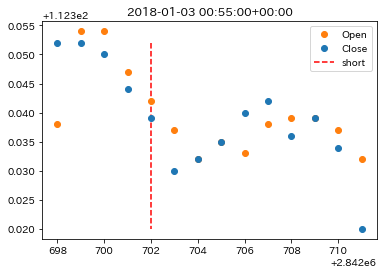

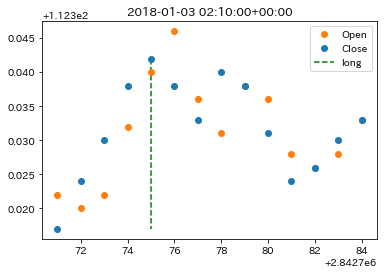

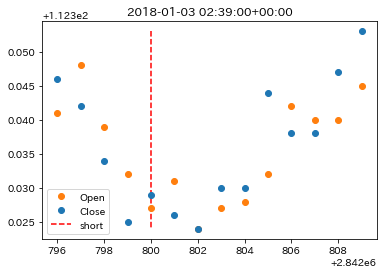

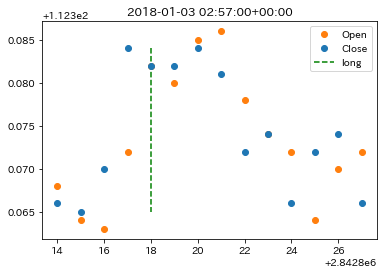

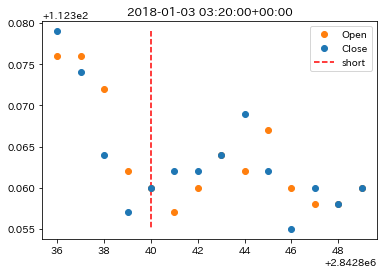

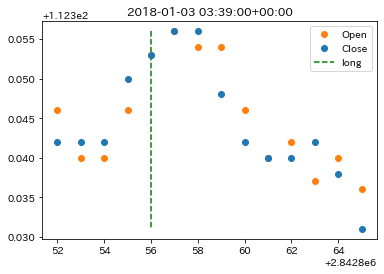

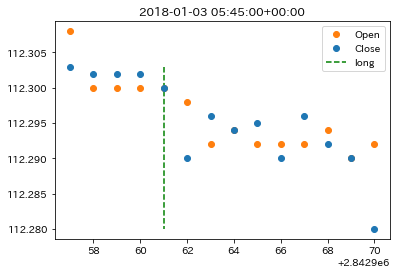

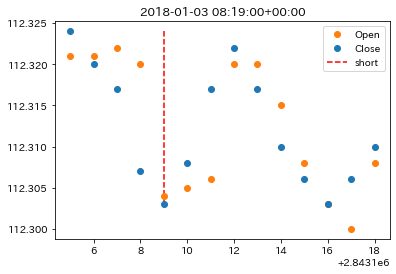

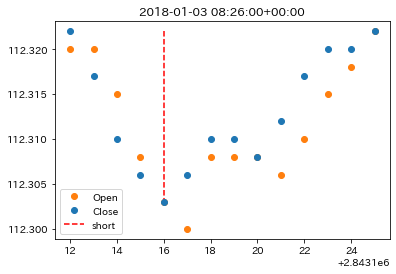

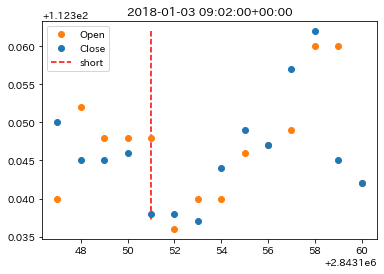

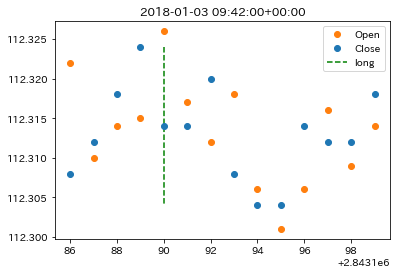

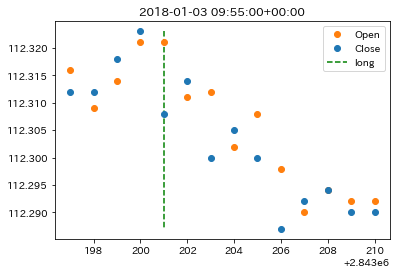

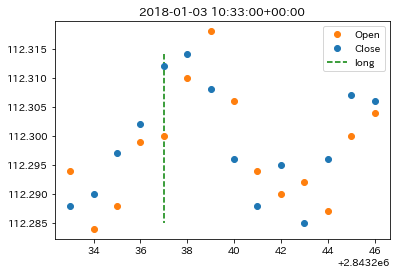

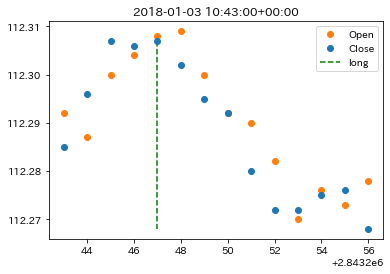

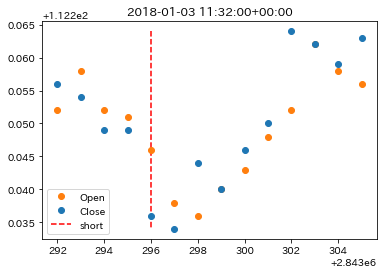

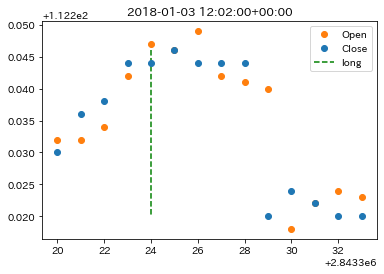

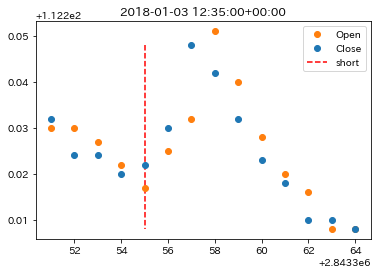

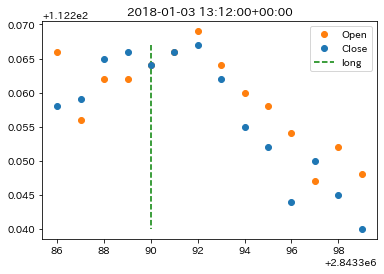

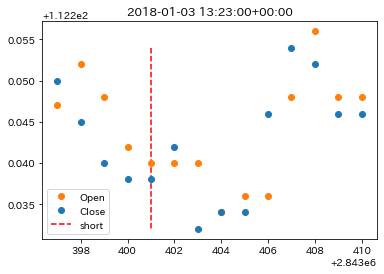

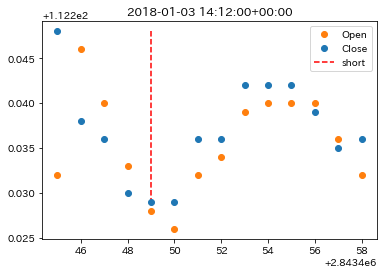

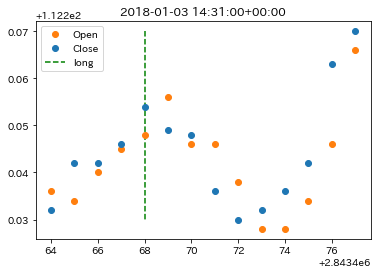

In [519]:
entry_plot(pos_df_m1, dfm1, m=10, b=4, type_='lose_head')

### range_ 逆張り

In [523]:
# バックテスト簡易版4
def back_test_easy4(df, m, start='', end='', gran='M1', range_thr=0.01):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    profit_list = []
    pos_count = 0
    tmp_i = 0
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    # 実行
    for i in range(4, len(df.index) - (1+m)):
        entry_rate = df.iat[i, 2] # 始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値(exit)
        # up or down (Open - Close) + なら下げ - なら上げ
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        ud4 = df.iat[i-4, 2] - df.iat[i-4, 5]
        range_ = abs((ud1 + ud2 + ud3) / 3)
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud4 < 0 and ud1 > 0 and ud2 > 0 and ud3 > 0 and range_ >= range_thr:
            if pos == 'None':
                profit = exit_rate - entry_rate - fee
                profit_list.append(profit)
                pos = 'entry_long'
                pos_count+=1
                tmp_i = i
        # 下降トレンドと判断しショート
        if ud4 > 0 and ud1 < 0 and ud2 < 0 and ud3 < 0 and range_ >= range_thr:
            if pos == 'None':
                profit = entry_rate - exit_rate - fee
                profit_list.append(profit)
                pos = 'entry_short'
                pos_count+=1
                tmp_i = i
        
    print('pos count: {:>5}, profit: {:>6.3f}'.format(pos_count, sum(profit_list)))

In [527]:
# バックテスト3
def back_test4(df, m, seed_money, start='', end='', gran='M1', lot=10, kly_rate='None', range_thr=0.01):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    tmp_i = 0
    assets = seed_money
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    pos_df = pd.DataFrame(columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])

    # 実行
    for i in range(4, len(df.index) - (1+m)):
        entry_rate = df.iat[i, 2] # 始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値
        # up or down (Open - Close) + なら下げ - なら上げ
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        ud4 = df.iat[i-4, 2] - df.iat[i-4, 5]
        range_ = abs((ud1 + ud2 + ud3) / 3)
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud4 < 0 and ud1 > 0 and ud2 > 0 and ud3 > 0 and range_ >= range_thr:
            if pos == 'None':
                pips = (exit_rate - entry_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'long', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                if pos_df.tail(1)['assets'].values[0] < 0:
                    break
                pos = 'entry_long'
                tmp_i = i
        # 下降トレンドと判断しショート
        if ud4 > 0 and ud1 < 0 and ud2 < 0 and ud3 < 0 and range_ >= range_thr:
            if pos == 'None':
                pips = (entry_rate - exit_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'short', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                if pos_df.tail(1)['assets'].values[0] < 0:
                    break
                pos = 'entry_short'
                tmp_i = i
        
    print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df, df

In [524]:
for i in range(1, 50):
    print('m: {}, '.format(i), end='')
    back_test_easy4(dfm1[dfm1['Time'].dt.year==2018], m=i)

m: 1, pos count: 10611, profit: -12.876
m: 2, pos count: 10611, profit: -8.846
m: 3, pos count: 10611, profit: -9.880
m: 4, pos count:  9999, profit: -7.253
m: 5, pos count:  9548, profit: -5.603
m: 6, pos count:  9126, profit: -5.905
m: 7, pos count:  8751, profit: -8.233
m: 8, pos count:  8392, profit: -5.094
m: 9, pos count:  8092, profit: -2.086
m: 10, pos count:  7817, profit:  0.450
m: 11, pos count:  7573, profit:  0.720
m: 12, pos count:  7328, profit: -4.766
m: 13, pos count:  7109, profit: -5.269
m: 14, pos count:  6903, profit: -7.758
m: 15, pos count:  6722, profit: -5.420
m: 16, pos count:  6543, profit: -9.188
m: 17, pos count:  6350, profit: -11.539
m: 18, pos count:  6214, profit: -11.645
m: 19, pos count:  6066, profit: -13.372
m: 20, pos count:  5934, profit: -12.803
m: 21, pos count:  5769, profit: -9.514
m: 22, pos count:  5663, profit: -6.662
m: 23, pos count:  5527, profit: -10.695
m: 24, pos count:  5428, profit: -9.508
m: 25, pos count:  5322, profit: -6.882
m: 

In [525]:
for i in range(1, 50):
    print('m: {}, '.format(i), end='')
    back_test_easy4(dfm1[dfm1['Time'].dt.year==2018], m=i, range_thr=0)

m: 1, pos count: 29892, profit: -48.707
m: 2, pos count: 29892, profit: -41.477
m: 3, pos count: 29892, profit: -41.523
m: 4, pos count: 27059, profit: -35.503
m: 5, pos count: 25088, profit: -28.938
m: 6, pos count: 23359, profit: -26.552
m: 7, pos count: 21869, profit: -26.344
m: 8, pos count: 20502, profit: -24.813
m: 9, pos count: 19375, profit: -21.539
m: 10, pos count: 18382, profit: -22.932
m: 11, pos count: 17443, profit: -17.835
m: 12, pos count: 16583, profit: -18.178
m: 13, pos count: 15805, profit: -16.057
m: 14, pos count: 15118, profit: -17.171
m: 15, pos count: 14478, profit: -7.706
m: 16, pos count: 13917, profit: -12.993
m: 17, pos count: 13347, profit: -14.282
m: 18, pos count: 12877, profit: -13.603
m: 19, pos count: 12408, profit: -17.911
m: 20, pos count: 11974, profit: -10.013
m: 21, pos count: 11607, profit:  0.921
m: 22, pos count: 11229, profit: -4.638
m: 23, pos count: 10892, profit: -15.148
m: 24, pos count: 10550, profit: -21.094
m: 25, pos count: 10248, pro

In [531]:
pos_df_range, df = back_test4(dfm1[dfm1['Time'].dt.year==2018], seed_money=1000000, m=10, range_thr=0.01)

pos count:  7817, assets: 1000004円


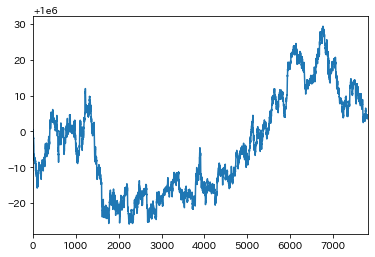

In [532]:
pos_df_range['assets'].plot()